# FioOptimizer Class
## from optimal-io-depth-search.py

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from argparse import ArgumentParser
import os
import sys
import importlib
directory_path = os.path.abspath(os.path.join('..','.'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
import autofio
importlib.reload(autofio)



<module 'autofio' from '/home/ec2-user/code/fio-parser/autofio.py'>

In [24]:
from utils.models import FioOptimizer, FioBase
from utils.parsers import parse_fio_config
blocksize = "9K"
readpercentages = ["0", "50", "100"]
config = 'fio.ini'
config = parse_fio_config(config)
config['bs'] = blocksize
config['rw'] = 'randrw'
results = {}
best_runs = {}
combined_results = pd.DataFrame()

for read_per in readpercentages:
    config['rwmixread'] = read_per
    optimizer = FioOptimizer(config=config)
    optimizer.find_optimal_iodepth()
    results[f'9K,randrw,{read_per}'] = optimizer
    best_runs[f'9K,randrw,{read_per}'] = optimizer.best_run

# Future TODO - version 1.5+
# determine protocol, 
# bundle fio with the repo
# system tunables (max tcp slot table entry, others)
# for multihost, we'll have to use an fio config file (fio expects this) and not with cmdline flags

/home/ec2-user/code/fio-parser/utils/models.py:161: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  retest_df_stddev = retest_df.std()
/home/ec2-user/code/fio-parser/utils/models.py:161: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  retest_df_stddev = retest_df.std()
read_latency              19.352361
read_iops                 83.947950
write_throughput         614.421923
write_latency             84.184942
write_iops                68.236427
read_percent               0.836660
total_throughput        1360.507810
total_iops               151.141761
avg_latency               52.695641
duration                   0.000000
blocksize                       Na

['9K']


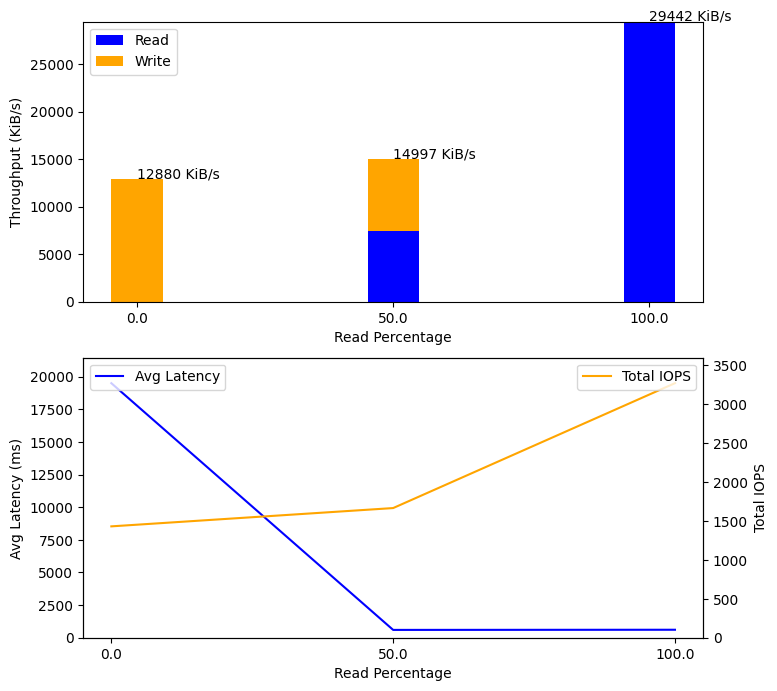

In [99]:
best_runs_df = pd.DataFrame()
for key, run in best_runs.items():
    # print(run.to_dict())
    best_runs_df: pd.DataFrame = best_runs_df.append(run.to_dict(), ignore_index=True)

best_runs_df
from reporting import pgreports
plot = pgreports.generate_rwmix_stacked_graphs(best_runs_df)
print(best_runs_df.blocksize.unique())
plot.savefig(f'{best_runs_df.blocksize}_rwmix.png')


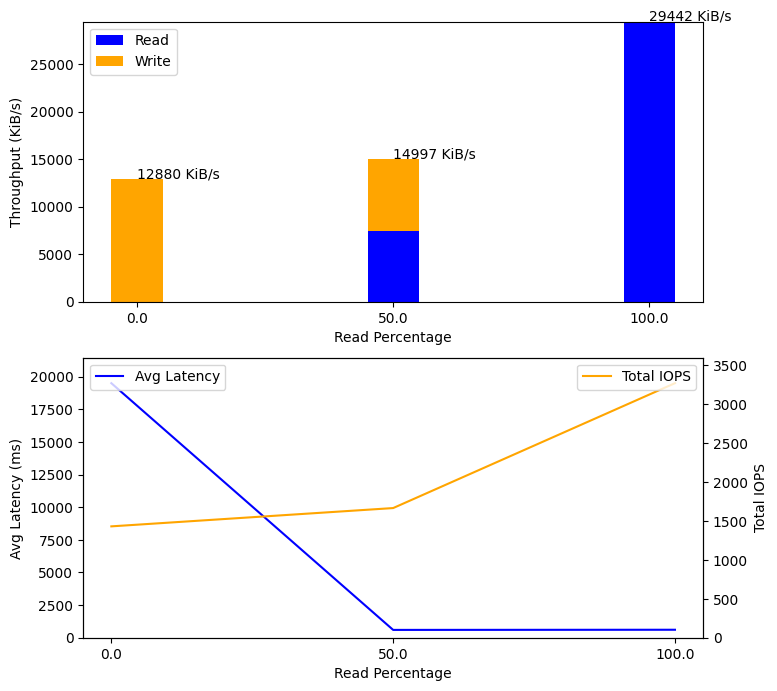

In [77]:
from datetime import datetime
# results = {}
combined_results = pd.DataFrame()
# results['9K,randrw,50'] = optimizer
# best_runs: pd.DataFrame = pd.DataFrame()
for key, value in results.items():
    data = value.to_DataFrame().reset_index()
    unpacked_tuple = key.split(',')
    data['blocksize'] = unpacked_tuple[0]
    data['rw'] = unpacked_tuple[1]
    combined_results = combined_results.append(data)

output_folder: str = os.path.join(os.getcwd(), 
                                    f'output/summary_{datetime.now().strftime("%Y%m%d_%H%M%S")}')

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 8), gridspec_kw={'height_ratios': [1, 1]})
# Create stacked (read and write) throughput graph for each blocksize on ax1
ax1.bar(x=best_runs_df['read_percent'], height=best_runs_df['read_throughput'], label='Read', color='blue', width=10)
ax1.bar(x=best_runs_df['read_percent'], height=best_runs_df['write_throughput'], label='Write', color='orange', width=10, bottom=best_runs_df['read_throughput'])
# add a comment to the graph for total throughput on each bar
for i in range(len(best_runs_df['read_percent'])):
    ax1.annotate(f"{best_runs_df['total_throughput'].values[i]:.0f} KiB/s",
            xy=(best_runs_df['read_percent'].values[i], best_runs_df['total_throughput'].values[i]),
            xytext=(best_runs_df['read_percent'].values[i], best_runs_df['total_throughput'].values[i] + 100)
)
ax1.set_xticks(best_runs_df['read_percent'])
ax1.set_xlabel('Read Percentage')
ax1.set_xticklabels(best_runs_df['read_percent'])
ax1.set_ylabel('Throughput (KiB/s)')
ax1.legend()

# Create line chart with avg_latency on right axis and total iops on left axis
ax2.plot(best_runs_df['read_percent'], best_runs_df['avg_latency'], label='Avg Latency', color='blue')
ax2.set_ylabel('Avg Latency (ms)')
ax2.set_xlabel('Read Percentage')
ax2.set_xticks(best_runs_df['read_percent'])
ax2.set_xticklabels(best_runs_df['read_percent'])
ax2.set_ylim(0, best_runs_df['avg_latency'].max() * 1.1)
ax2.legend(loc='upper left')
ax3 = ax2.twinx()
ax3.plot(best_runs_df['read_percent'], best_runs_df['total_iops'], label='Total IOPS', color='orange')
ax3.set_ylabel('Total IOPS')
ax3.set_ylim(0, best_runs_df['total_iops'].max() * 1.1)
ax3.legend(loc='upper right')



In [78]:
best_runs_df['avg_latency']

0    19500.597656
1      598.765720
2      610.781128
Name: avg_latency, dtype: float64

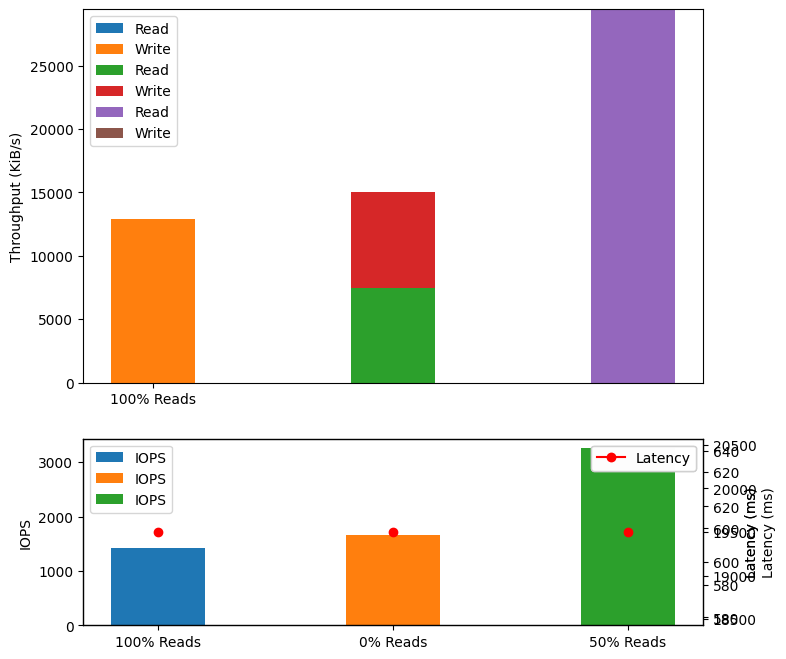

In [41]:
# data = pd.DataFrame(optimizer.best_run.to_dict(), index=[0])
# print(data.columns)
from reporting import pgreports
# graph = pgreports.generate_rwmix_stacked_graph(combined_results)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define figure size and grid layout
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 8), gridspec_kw={'height_ratios': [2, 1]})

# Create throughput graph
for bs, df in best_runs_df.groupby('blocksize'):
    for rwmixread, group in df.groupby('read_percent'):
        read_data = group['read_throughput']
        write_data = group['write_throughput']
        labels = [f"{round(rwmixread)}% Reads"]
        x = np.arange(len(labels))
        width = 0.35
        ax1.bar(labels, read_data, width=width, label='Read')
        ax1.bar(labels, write_data, bottom=read_data, width=width, label='Write')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_ylabel('Throughput (KiB/s)')
ax1.legend()
# Create IOPS/latency graph
for bs, df in best_runs_df.groupby('blocksize'):
    for rwmixread, group in df.groupby('read_percent'):
        iops_data = group['read_iops'] + group['write_iops']
        latency_data = group['avg_latency']
        labels = [f"{round(rwmixread)}% Reads"]
        ax2.bar(labels, iops_data, label='IOPS', width=0.4)
        ax2.set_ylabel('IOPS')
        ax2.tick_params(axis='y')
        ax2.legend(loc='upper left')
        ax3 = ax2.twinx()
        ax3.plot(labels, latency_data, marker='o', label='Latency', color='red')
        ax3.set_ylabel('Latency (ms)')
        ax3.tick_params(axis='y')
        ax3.legend(loc='upper right')

plt.show()
    

In [2]:
from utils import models
from utils.models import FioOptimizer, FioBase

# fio_params = {"--bs": "16k", 
#               "--name": "job1", 
#               "--ioengine":"libaio", 
#               "--iodepth": "1", 
#               "--size": "300m", 
#               "--filename": "/mnt/testvol/test.fio", 
#               "--direct": "1",
#               "--rw": "randrw",
#               "--runtime": "2s",
#               "--time_based": None,
#               "--group_reporting": None,
#               "--output-format": "json",
#               "--norandommap": None,
#               "--dedupe_percentage": 0,
#               "--buffer_compress_percentage": 50,
#               "--buffer_compress_chunk": 4096,
#               "--buffer_pattern": "\"aaaa\""}
# param_list: list = [f"{k}={v}" for k, v in fio_params.items()]
# print(fio_params)
# print(param_list)

fio = FioOptimizer(min=1, max=40, slices=5, fio_params=fio_params)

# # print(f"Fio Config: {fio.config}")

# is_optimial: bool = False

# starting_io_depths: list = [fio.min, fio.max]    # gotta start some where

# for io_depth in starting_io_depths:
#     fio.config['--iodepth'] = io_depth
#     # print(fio.config)
#     fio.prepare_and_run_fio(io_depths=[io_depth])
#     # fio.runs[io_depth] = fio_run


NameError: name 'fio_params' is not defined

In [5]:
fio.find_optimal_iodepth()
print(fio.best_run)

ERROR:root:Error code: 1
Error Message: b'No jobs(s) defined\n\n'


RuntimeError: Error code: 1
Error Message: b'No jobs(s) defined\n\n'

In [15]:
import pandas as pd 
import json
import ipywidgets as widgets
df = pd.DataFrame([x.__dict__ for x in fio.runs.values()])
print(df.columns)
# df.plot(x='io_depth', y='iops_latency_ratio', kind='scatter')
def my_plot(x:str, y:str, kind:str):
    df.plot(y=y, x=x, kind=kind)
# allow user to select a column from df.columns to graph as x and y for input into df.plot
# widgets.interact(df.plot, x=df.columns, y=df.columns)

widgets.interact(my_plot, x=df.columns, y=df.columns, kind=['scatter', 'line'])



Index(['read_bandwidth', 'read_latency', 'read_iops', 'write_bandwidth',
       'write_latency', 'write_iops', 'total_bandwidth', 'timestamp',
       'duration', 'total_iops', 'io_depth', 'jobs', 'ERROR_CODE',
       'iops_latency_ratio', 'avg_latency'],
      dtype='object')


interactive(children=(Dropdown(description='x', options=('read_bandwidth', 'read_latency', 'read_iops', 'write…

<function __main__.my_plot(x: str, y: str, kind: str)>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import scipy
df = pd.read_csv('output/4k_randrw/80/fio.csv')
# write a function that accepts a pandas dataframe and returns a plot

def my_plot(x:str, y:str, kind:str):
    df.plot(y=y, x=x, kind=kind)

widgets.interact(my_plot, x=df.columns, y=df.columns, kind=['scatter', 'line'])


interactive(children=(Dropdown(description='x', options=('io_depth', 'read_throughput', 'read_latency', 'read_…

<function __main__.my_plot(x: str, y: str, kind: str)>

##Notes

    # test limits (min, max)
    # test midpoint between limits
    # average results of min+midpoint and max+midpoint
    # 
    # divide total from min and max into n buckets, then go test all of them,
    # sort them 
    # range(min, max, (abs(max-min))/5)
    # slices = 5 
    # 10, 20, 2 # ((20-10)/slices = 2)
    # k = [10, 12, 14, 16, 18]
    # when I do the loop, test if k[n] is already tested
    # find the best results from min, max, k[]
    

    # while not is_optimial:
    #     sorted_runs_by_iops: list[FioBase] = sorted(self.runs, key=self.runs.get('total_iops'), reverse=True)
    #     # are we going up or down?
    #     if sorted_runs_by_iops[0].io_depth - sorted_runs_by_iops[1].io_depth <= 1:
    #         is_optimial = True
    #         self.optimal_queue_depth = sorted_runs_by_iops[0]
    #         return 
    #     else: 
    #         next_io_depth = ((sorted_runs_by_iops[0].io_depth + sorted_runs_by_iops[1].io_depth) // 2)
    #         if next_io_depth in self.runs:
    #             next_io_depth = 
    #         else:
    #             self.prepare_and_run_fio(io_depth=next_io_depth)
    

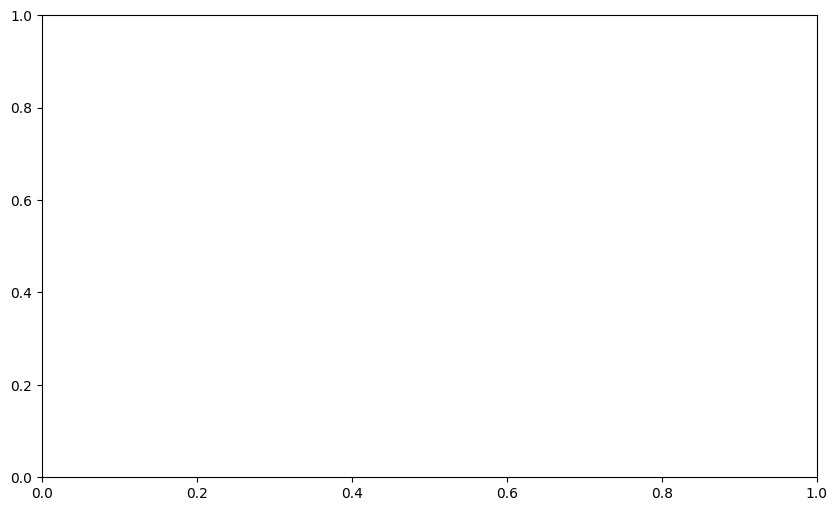

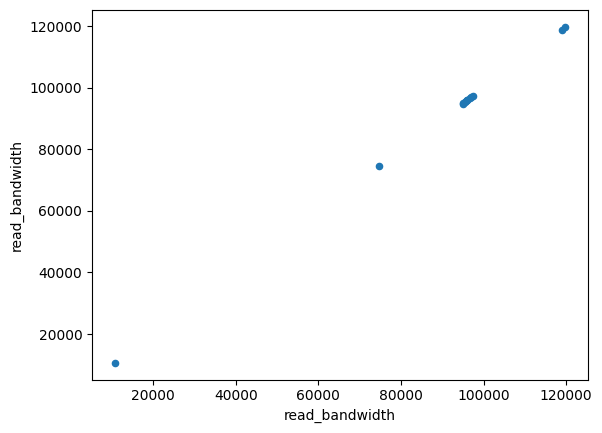

interactive(children=(Dropdown(description='x', options=('read_bandwidth', 'read_latency', 'read_iops', 'write…

<function __main__.my_plot(x: str, y: str, kind: str)>

In [16]:
import ipywidgets as widgets
import numpy as np
import matplotlib
# fio is my variable with all the good data in it

def trendline(x):
    return 0.5 * x + 100

plt, ax = matplotlib.pyplot.subplots( figsize=(10, 6) )
df = fio.to_DataFrame()



# generate a chart of iops vs latency
def my_plot(x:str, y:str, kind:str):
    trendline = np.poly1d(np.polyfit(df[x], df[y], 1))
    ax.plot(df[x], trendline(df[x]), color='red')
    df.plot(y=y, x=x, kind=kind)
    # add a trendline to the chart
    
     

widgets.interact(my_plot, x=df.columns, y=df.columns, kind=['scatter', 'line'])


In [ ]:
def overall_response_time(throughput: list, latency: list):
    """
    Calculate the overall response time for a given throughput and latency.
    """
    curve = fit_latency_curve(throughput, latency)
    area_under_curve = curve.integ()
    response_time = (1/throughput) * area_under_curve
    return response_time


import numpy as np
import pandas as pd
def fit_latency_curve(throughput: list, latency: list):
    """    Fit a curve to the latency data using a weighted least squares method.    """
    curve = np.polynomial.polynomial.Polynomial.fit(x=throughput, y=latency, deg=2, w=1/throughput)
    return curve

# example_data = np.genfromtxt('output/4k_randrw/80/fio.csv', delimiter=',', names=True)
# ORT = overall_response_time(example_data.total_throughput, example_data.avg_latency)
# df = pd.DataFrame(example_data[['total_throughput', 'avg_latency']])

example_data = pd.read_csv('output/8k_randrw/10/fio.csv')
throughput = example_data.total_throughput
latency = example_data.avg_latency
curve = np.polynomial.polynomial.Polynomial.fit(x=throughput, y=latency, deg=2, w=1/throughput)
area = curve.integ()
print(f'curve: {curve} \n area: {area} ')
# throughput_x_new = np.linspace(throughput.min(), throughput.max(), throughput.count())
# latency_mathed = np.polyval(curve, throughput_x_new)
print(f'curve: {curve} \n area: {area} ') # \n throughput_x_new: {throughput_x_new} \n latency_mathed: {latency_mathed}')

# print(df)
# print(f't_new: {t_new}') # \n l_new: {l_new}')



In [107]:
example_data = pd.read_csv('output/128k_rw/10/fio.csv')
example_data.sort_values(by='io_depth', inplace=True)
throughput = example_data.total_throughput
latency = example_data.avg_latency
latency_curve = np.polynomial.polynomial.Polynomial.fit(x=throughput, y=latency, deg=2, w=1/throughput) # w(x) in the paper 
area_under_latency_curve = latency_curve.integ()                                                        # a(x) in the paper
x=0.72
# response_time = area_under_latency_curve(x)                                                             # r(x) in the paper
response_time = latency_curve(x)                                                             # r(x) in the paper
ATP = x/response_time                                                                                # ATP(x) in the paper

def overall_response_time(throughput: list, latency: list, x_val: int):
    """
    Calculate the overall response time for a given throughput and latency.
    """
    latency_curve = np.polynomial.polynomial.Polynomial.fit(x=throughput, y=latency, deg=2, w=1/throughput)     # w(x) in the paper 
    area_under_latency_curve = latency_curve.integ()                                                            # a(x) in the paper 
    response_time = area_under_latency_curve(x_val) / x_val                                                     # r(x) in the paper
    return response_time

def accelerated_throughput_power(x_val: int, riot: int):
    return (x_val**(1+riot))

ORT = overall_response_time(throughput, latency, throughput.max())
# ATP = [overall_response_time(throughput, latency, x) for x in throughput]
riot = 1 # alpha in the paper

print(f'curve: {curve} \n area: {area} \n ORT: {ORT}')
print(ATP)



curve: 1765.1663874029543 + 2517.9624362194554·x¹ + 1761.7086751494098·x² 
 area: 0.0 + 661594070.413758·x¹ + 471873084.94422555·x² + 220099366.94790402·x³ 
 ORT: 1549.6747643898996
0.00046952744872882723


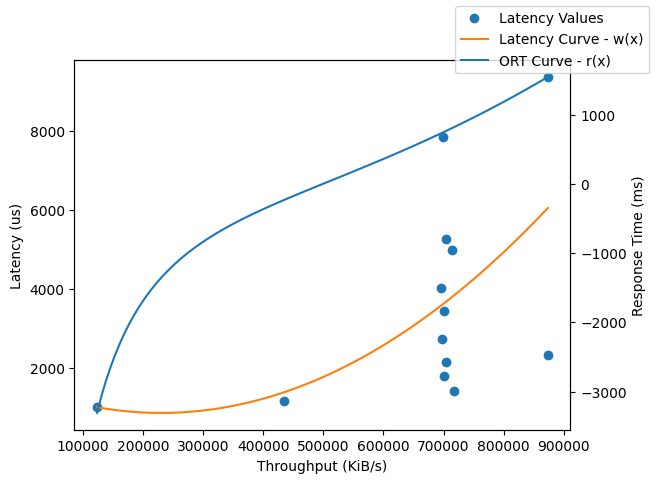

[-3309.24614963895, -3061.011091111846, -2840.851786103581, -2644.3423471267743, -2467.92660516102, -2308.714480922923, -2164.3330081300587, -2032.815628718257, -1912.5187602902533, -1802.058106634129, -1700.259467566787, -1606.120337868931, -1518.7796318545911, -1437.4935959671986, -1361.616482438638, -1290.584921121314, -1223.9051894062306, -1161.1427720333759, -1101.9137442243334, -1045.87761713933, -992.7313640982244, -942.2044063035486, -894.0543829534157, -848.0635662281024, -804.035809291535, -761.7939370874078, -721.1775067502307, -682.0408779547948, -644.2515442908723, -607.6886853774638, -572.2419063834105, -537.8101372523066, -504.3006685127257, -471.62830430211807, -439.7146163103103, -408.48728488678444, -377.87951565782134, -347.82952174695436, -318.28006315021986, -289.1780360386756, -260.47410578664005, -232.12237838911838, -204.08010566345502, -176.3074202509267, -148.76709696209025, -121.42433746034759, -94.24657566379274, -67.20330157622418, -40.265901542765064, -13.

In [103]:
import matplotlib.pyplot as plt

throughput_x_new = np.linspace(throughput.min(), throughput.max(), throughput.count())
latency_mathed = latency_curve(throughput_x_new)


# Find the value of latency_mathed at 73% of the way along the line
point_idx = int(0.73 * len(latency_mathed))
x_val = throughput_x_new[point_idx]
y_val = latency_mathed[point_idx]

throughput_vals = np.linspace(throughput.min(), throughput.max(), 100)
response_time_vals = [overall_response_time(throughput, latency, x) for x in throughput_vals]

# Plot the throughput/latency curve and the response time curve
fig, ax1 = plt.subplots()

ax1.plot(throughput, latency, 'o', label='Latency Values')
ax1.plot(throughput_vals, latency_curve(throughput_vals), '-', label='Latency Curve - w(x)')
ax1.set_xlabel('Throughput (KiB/s)')
ax1.set_ylabel('Latency (us)')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.plot(throughput_vals, response_time_vals, label='ORT Curve - r(x)')
ax2.set_ylabel('Response Time (ms)')
ax2.tick_params(axis='y')

fig.legend(loc='upper right')
plt.show()
print(response_time_vals)


